Reference:  

* https://blog.csdn.net/kenneth_yu/article/details/78478356

* https://blog.csdn.net/qq_30615903/article/details/80776715  

* https://spinningup.openai.com/en/latest/algorithms/ddpg.html  



## Policy Gradient

[Policy Gradient](https://papers.nips.cc/paper/1999/file/464d828b85b0bed98e80ade0a5c43b0f-Paper.pdf) is to learn the control policy for continuous actions. Its basic idea is that:  Using a probability distribution $\pi_{\theta}(s_t|\theta^{\pi})$ to represent the optimal policy of each step, and sampling optimal action according to the probabilify distribution function:
$$a_t\sim \pi_{\theta}(s_t|\theta^{\pi})$$ 

Sampling action from the distribution function is stochastic; the learned policy is also a stochastic policy. 

## Deterministic Policy Gradient

[Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) is an improvement of PG: Actions are determined by a function $\mu$: $$a_t\sim \mu_{\theta}(s_t|\theta^{\mu})$$ 

The function $\mu$ is the optimal policy, which is no more a stochastic policy but a deterministic policy. 

DPG is to solve the following problems of PG:

1. Even the optimal policy distribution is learned, we still need to sample from the distribution to get a specific action. But action is usually high dimensional vector, sampling action in such high dimensional space means high computation cost. 

2. In the learning process of PG, we need to do integral over the whole action space to calculate the gradient:
$$\nabla_{\theta} = \int_{S}\int_{A}\rho(s)\pi_{\theta}(a|s)Q^{\pi}(s, a)\, da \, ds$$ This integral can be approximately computed by Monte Carlo Sampling, but still it is computationally expensive. 

DPG uses the actor-critic structure and combines traditional Q-learning or Graident Q-learning, it learns a deterministic optimal policy function. 

##  Deep Deterministic Policy Gradient

[Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) is an enhanced version of DPG. Next we introduce DDPG by taking the envrionment of Open Gym as an example. 

**Quick Review**:
* Deterministic policy $\mu$: a policy functoin from which each step's action can be obtained given the state, $a_{t} = \mu(s_{t})$
* Policy network: the neural network we want to approximate $\mu$ function, parameter is $\theta^{\mu}$
* behavior policy $\beta$: the training process of RL algorihtm has to consider both `exploration` and `exploit`; exploration is to find potential optimal policy, thus we introduce random noise to the mechanism of obtaining action: changing the determining mechanism of action into a stochastic process, and sample action from the stochastic process. This kind of training way is called off-policy training. Note: the policy $\beta$ is not the optimal policy we want learn, its role is just to generate action during the training process so that we can build our training dataset. We use the obtained dataset to train the policy function $\mu$ to get the optimal function. 
* $Q$ function: action-value function; the expected cumulative reward $R_t$ we may get if we choose action $a_t$ at state $s_t$ and following policy $\mu$ afterward. We can not calculate all the $Q$ value, so we use a neural network to do function approximation. 

$$Q^u (s_t, a_t) = E[r(s_t, a_t) + \gamma Q^u (s_{t+1}, \mu(s_{t+1}))]$$

* Q network: a neural network used to approximate Q function, parameter is $\theta^Q$ 

* Performance objective: the measure of policy $\mu$. $$\begin{aligned} J_{\beta}(\mu)&=\int_S\rho^{\beta}(s)Q^{\mu}(s, \mu(s))\, ds \\ &= E_{S\sim\rho^{\beta}}[Q^{\mu}(s, \mu(s))]\end{aligned}$$ 

    Note: 
    * $s$ is state, sampled from behavior policy $\beta$, its pdf is $\rho^{\beta}$
    * $Q^{\mu}(s, \mu(s))$ is $Q$ value at state $s$ and following policy $\mu$. $J_{\beta}(\mu)$ is the expectation of $Q^{\mu}(s, \mu(s))$ when $s$ follows $\rho^{\beta}$

* Training objective: maximize $J_{\beta}(\mu)$ and minimize the loss of $Q$ network at the same time. 

* Strategy of optimizing $\mu$: $$\mu = argmax_{\mu} J(u)$$

* Strategy of optimizing $Q$ network: minimize loss of $Q$ network; use SGD to find optimal $\theta^Q$

**DDPG architecture**:

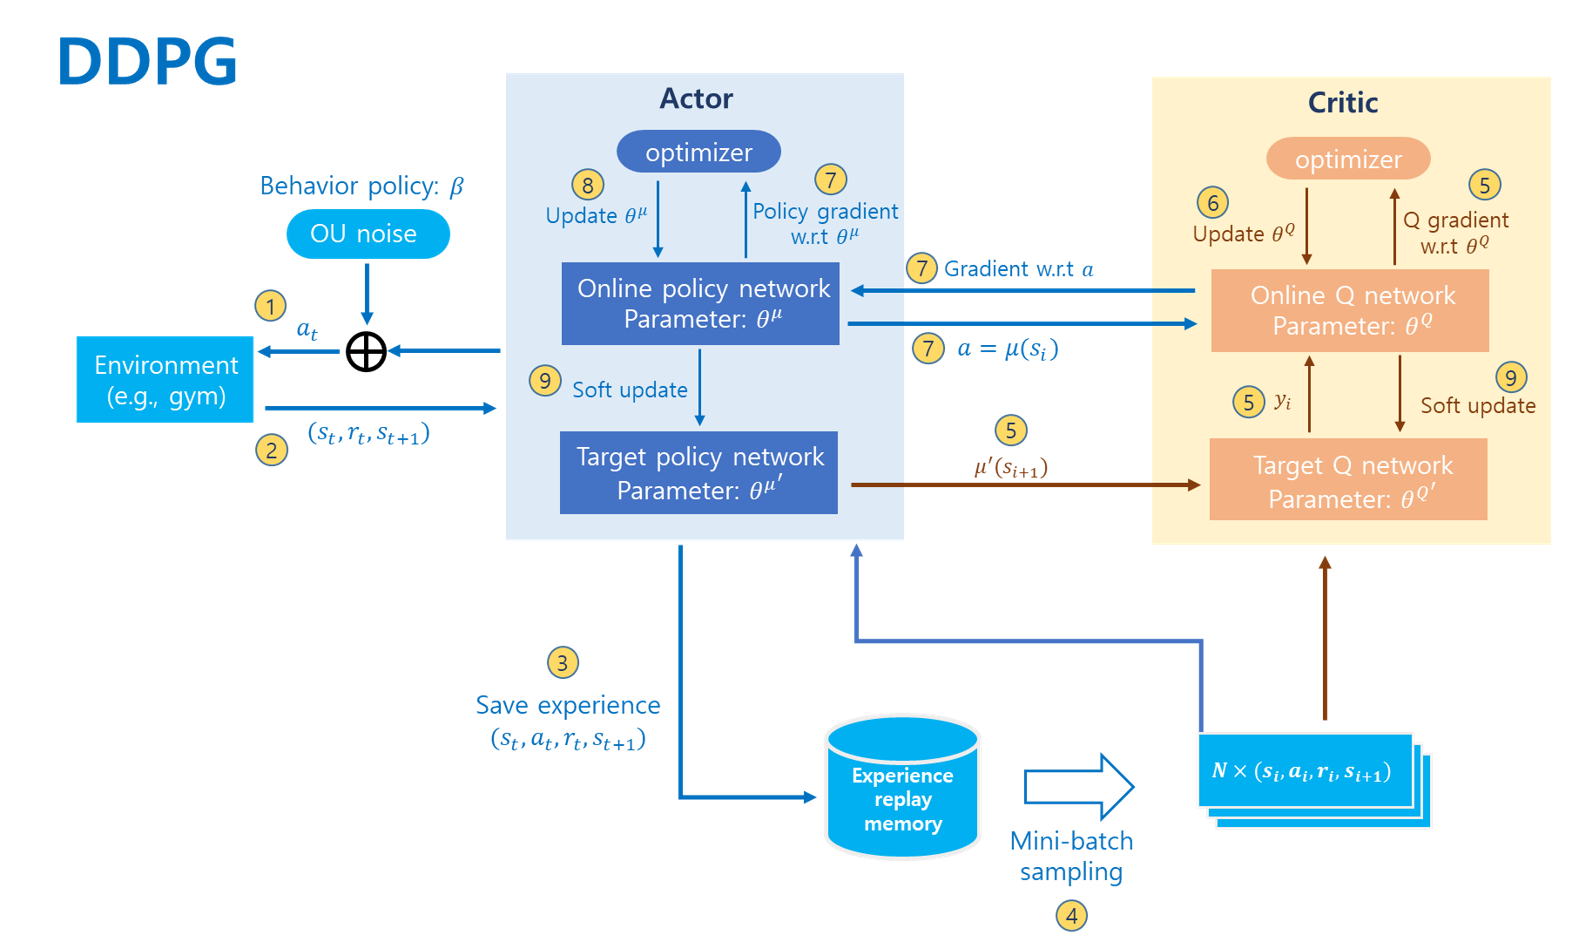

**DDPG algorithm**:

* Initilize the parameter of online network of Actor and Critic: $\theta^{Q}$ and $\theta^{\mu}$
* Copy parameter of online network into corresponding target network: $\theta^{Q^{\prime}} \leftarrow \theta^{Q},
\theta^{\mu^{\prime}} \leftarrow \theta^{\mu}$ 
* Initilize replay memory buffer $R$
* for each episode:
    * Initialize [OU process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)
    * for t = 1$\sim T$ :
        1. Actor samples $a_t$ by following behaviour policy $\beta$ and interacts with environment. $$a_t=\mu(s_t|\theta^{mu} + \mathcal{N}_t$$
        Note: Behavior policy is the stochastic process that combines current online policy $\mu$ and $OU$ noise, $a_t$ is sampled from the stochastic process  
        2. environment executes $a_t$, releases reward $r_t$ and new state $s_{t+1}$
        3. Store the `transition` ($ s_t, a_t, r_t, s_{t+1}$) into replay memory buffer R, which will be used the dataset for training online networks
        4. Sample $N$ transitions as a minibatch as the training data points for online policy network and online $Q$ network. 
        5. Calculate gradient of online $Q$ network:  
          Loss of $Q$ network: $$L = \frac{1}{N}\sum_i(y_i-Q(s_i, a_i|\theta^Q))^2$$  
          $$y_i=r_i + \gamma Q^{\prime}(s_{i+1}, \mu^{\prime}(s_{i+1}|\theta^{\mu^{\prime}})|\theta^{Q^{\prime}})$$
          Then calculate: $\nabla_{\theta^{Q}}L$  
          Note: calculation of $y_i$ uses target policy netowrk $\mu^{\prime}$ and target $Q$ network $Q^{\prime}$  
        6. Update onlne $Q$: update $\theta^{Q}$ by using optimzier e.g., Adam
        7. Calculate policy gradient of online policy network:
          In the DPG paper, the policy gradient using off-policy training is given as:
          $$\nabla_{\theta^{\mu}} \approx E_{s\sim \rho^{\beta}}[\nabla_a Q(s, a|\theta^Q)|_{a=\mu(s)} \cdot \nabla_{\theta^{\mu}}\mu(s|\theta^{\mu})]$$
          In other words, the policy gradient when $s$ follows $\rho^{\beta}$ is the expectation of $\nabla_{a}Q\cdot \nabla_{\theta^{\mu}}\mu$
          We use Monte-carlo to approxiamtely compute the expectation:
          $$\nabla_{\theta^{\mu}} \approx \frac{1}{N}\sum_i(\nabla_a Q(s, a|\theta^Q)|_{s=s_i, a=\mu(s_i)}\cdot \nabla_{\theta^{\mu}}\mu(s|\theta^{\mu})|_{s=s_i})$$
          
        8. update online policy network $\mu$: update $\theta^{\mu}$ by using optimzier e.g., Adam
        9. soft update target network $\mu^{\prime} $ and $Q^{\prime}$, usually $\tau$= 0.001:
        $$\begin{cases}\theta^{Q^{\prime}} \leftarrow \tau\theta^Q + (1-\tau)\theta^{Q^{\prime}}\\ \theta^{\mu^{\prime}}\leftarrow \tau\theta^{\mu} + (1-\tau)\theta^{{\mu}^{\prime}}\end{cases}$$ 